In [2]:
cd IMGS-789-Advanced-Robust-ML-for-Interdisciplinary-Imaging-Science-Applications/group_project/

[Errno 2] No such file or directory: 'IMGS-789-Advanced-Robust-ML-for-Interdisciplinary-Imaging-Science-Applications/group_project/'
/home/ckb2084/research/IMGS-789-Advanced-Robust-ML-for-Interdisciplinary-Imaging-Science-Applications/group_project


/home/ckb2084/conda/envs/pytorch/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [ ]:
# Neccesary imports
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from time import time
import random
import glob, os

# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from scipy.ndimage.filters import gaussian_filter1d
import torchvision.models as models
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from accelerate import Accelerator
cm = plt.get_cmap('RdYlBu')
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import LayerNorm
import math
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.colors as mcolors

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import gaussian_kde


/tmp/ipykernel_3733183/2093688170.py:17: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


In [285]:
%%time
# Import all the data

data = pd.read_pickle('grism_specPT.pkl')
data_sed = pd.read_pickle('sed_fitting.pkl')
# data_photo = pd.read_pickle('photo_data.pkl')

CPU times: user 1.22 s, sys: 1.94 s, total: 3.16 s
Wall time: 19.1 s


In [286]:
data_sed_chi_l5 = data_sed[data_sed['best.reduced_chi_square'] <= 5.0]
data_sed_chi_l5.reset_index(drop=True, inplace=True)

In [287]:
# Check for NaN values in the data_sed_chi_l5 DataFrame
data_sed_chi_l5.isnull().any().any()


np.False_

In [288]:
id = [int(i) for i in data_sed_chi_l5['id']]
print(id)
print(len(id))

[1256, 1254, 1259, 1261, 1262, 1263, 1264, 1267, 1265, 1275, 1268, 1278, 1273, 1279, 1282, 1281, 1293, 1277, 1294, 1288, 1280, 1287, 1291, 1286, 1300, 1289, 1270, 1301, 1295, 1296, 1307, 1306, 1314, 1316, 1313, 1319, 1310, 1315, 1320, 1298, 1323, 1318, 1321, 1327, 1334, 1330, 1336, 1329, 1305, 1324, 1332, 1340, 1339, 1337, 1341, 1342, 1347, 1343, 1344, 1346, 1325, 1349, 1345, 1353, 1350, 1333, 1363, 1357, 1364, 1371, 1367, 1358, 1373, 1368, 1370, 1354, 1377, 1379, 1381, 1376, 1380, 1374, 1335, 1383, 1384, 1389, 1387, 1386, 1395, 1390, 1396, 1400, 1385, 1401, 1402, 1392, 1405, 1412, 1398, 1409, 1414, 1417, 1415, 1403, 1413, 1421, 1416, 1393, 1424, 1408, 1425, 1420, 1426, 1422, 1427, 1432, 1419, 1433, 1440, 1442, 1434, 1443, 1446, 1445, 1447, 1441, 1453, 1458, 1459, 1449, 1462, 1456, 1460, 1469, 1457, 1473, 1471, 1474, 1475, 1485, 1477, 1472, 1480, 1466, 1481, 1493, 1496, 1489, 1500, 1497, 1505, 1504, 1502, 1506, 1501, 1492, 1503, 1509, 1507, 1517, 1515, 1520, 1512, 1498, 1508, 1522, 151

In [289]:
data = data.iloc[id]
data.reset_index(drop=True, inplace=True)
len(data) , len(data_sed_chi_l5)

(5253, 5253)

In [290]:
len(data[data['SNR']>=2.5]), len(data_sed_chi_l5)

(3193, 5253)

In [291]:
data_subset = data[data['SNR']>=2.5]
# data_subset = data[data['z']<1.7]
# data_subset = data.copy()
data_subset.reset_index(drop=True, inplace=True)
data_subset

,grism_id,wavelength,flux,z,SNR,continuum_sub_flux
0,aegis-30-G141_16669,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.37,11.989796,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,aegis-03-G141_16663,"[10208.409432389317, 10209.33721533346, 10210....","[0.2157363286689506, 0.22082816680427558, 0.22...",1.09,11.412162,"[0.21309762829793683, 0.21817746792271925, 0.2..."
2,aegis-09-G141_16690,"[10208.409432389317, 10209.33721533346, 10210....","[0.00778524999229816, 0.005854441809619882, 0....",2.23,12.238806,"[0.007557014614129983, 0.005625126513444418, 0..."
3,aegis-30-G141_16702,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.18,4.275591,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,aegis-10-G141_16745,"[10208.409432389317, 10209.33721533346, 10210....","[0.019086188014154324, 0.017503420137809065, 0...",0.71,2.922414,"[0.01857205910211526, 0.016986701212360688, 0...."
...,...,...,...,...,...,...
3188,cosmos-17-G141_19115,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.72,4.791579,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3189,cosmos-17-G141_19083,"[10208.409432389317, 10209.33721533346, 10210....","[0.16553222677101787, 0.16052519630523887, 0.1...",1.27,3.645833,"[0.16013470536491314, 0.15510029150911223, 0.1..."
3190,cosmos-27-G141_19151,"[10208.409432389317, 10209.33721533346, 10210....","[-0.04439846029922192, -0.0416832341989712, -0...",1.56,6.326241,"[-0.04469920371904212, -0.0419853716504135, -0..."
3191,cosmos-17-G141_19049,"[10208.409432389317, 10209.33721533346, 10210....","[0.04307704345128237, 0.04117447165067361, 0.0...",1.37,14.785714,"[0.042789346243949464, 0.04088579666523472, 0...."


In [292]:

from SpecPT import (
    SpecPT, 
    SpecPTForRedshift, 
    CustomLoadDataset_Autoencoder,
    Swish,
    # CustomLoadDataset_Redshift, 
    NMADLoss, 
    evaluate
)

In [346]:
class EnhancedSpecPTForRedshift(nn.Module):
    def __init__(self, pretrained_model, additional_features_dim, output_features=1, num_mlp_blocks=5, mlp_dim=512, dropout_rate=0.2):
        super(EnhancedSpecPTForRedshift, self).__init__()
        
        self.encoder = pretrained_model.transformer_encoder
        self.proj_to_d_model = pretrained_model.proj_to_d_model
        self.forward_conv = pretrained_model.forward_conv
        
        # Fine-tune the last few layers of the encoder
        for param in list(self.encoder.parameters())[-2:]:
            param.requires_grad = True
        
        # Projection layer for additional features
        self.additional_projection = nn.Sequential(
            nn.Linear(additional_features_dim, 512),
            nn.LayerNorm(512),
            Swish(),
            nn.Dropout(dropout_rate),
            nn.LayerNorm(512)
        )
        self.additional_bn = nn.BatchNorm1d(512)
        
        # Early fusion layer before attention
        self.pre_attention_fusion = nn.Sequential(
            nn.LayerNorm(1024),
            nn.Linear(1024, 512),
            Swish(),
            nn.Linear(512, 512),
            Swish(),
            nn.Dropout(dropout_rate),
            nn.LayerNorm(512)
        )
        
        self.attention = nn.MultiheadAttention(embed_dim=512, num_heads=8,dropout=dropout_rate)
        self.gradient_clip = 1.0
        self.flatten = nn.Flatten(1)
        self.mlp_blocks = nn.Sequential(
            *[ImprovedResidualMLPBlock(mlp_dim, mlp_dim, dropout_rate) for _ in range(num_mlp_blocks)]
        )
        
        self.prediction = nn.Sequential(
            nn.Linear(mlp_dim, mlp_dim // 2),
            Swish(),
            nn.Dropout(dropout_rate),
            nn.Linear(mlp_dim // 2, output_features),
            nn.Softplus()
        )
        
    def forward(self, x, additional_data):
        batch_size = x.size(0)
        
        # Process spectral data
        x = x.unsqueeze(1)
        # print(x.shape)
        x = self.forward_conv(x)
        # print(x.shape)

        # Flatten and project
        x = self.flatten(x)  # Flatten all dimensions except batch
        # print(x.shape)
        x = self.proj_to_d_model(x)
        # print(x.shape)
        x = x.view(batch_size, -1, 512)  # Reshape to (batch_size, seq_len, features)
        # print(x.shape)
        
        # Encode spectral features
        encoded_features = self.encoder(x.transpose(0, 1))  # (seq_len, batch_size, features)
        # print(encoded_features.shape)
        encoded_features = encoded_features.transpose(0, 1)  # (batch_size, seq_len, features)
        # print(encoded_features.shape)
        
        # Process additional data
        # print(additional_data.shape)
        additional_features = self.additional_projection(additional_data)
        # additional_features = self.additional_bn(additional_features)
        # print(f'additional_features : {additional_features.shape}')
        additional_features = additional_features.unsqueeze(1)  # Add sequence dimension
        # print(additional_features.shape)
        
        # Combine features
        combined_features = torch.cat([encoded_features, additional_features], dim=-1)
        # print(combined_features.shape)
        fused_features = self.pre_attention_fusion(combined_features)
        # print(fused_features.shape)
        
        # Apply attention
        fused_features = fused_features.transpose(0, 1)  # (seq_len, batch_size, features)
        attn_output, _ = self.attention(fused_features, fused_features, fused_features)
        attn_output = attn_output.transpose(0, 1)  # (batch_size, seq_len, features)
        
        # Residual connection
        x = attn_output + fused_features.transpose(0, 1)
        
        # Process through MLP blocks
        x = self.mlp_blocks(x)
        
        # Final prediction - average over sequence dimension
        x = x.mean(dim=1)
        redshift = self.prediction(x)
        
        return redshift

class ImprovedResidualMLPBlock(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate):
        super(ImprovedResidualMLPBlock, self).__init__()
        self.linear1 = nn.Linear(input_dim, output_dim)
        self.linear2 = nn.Linear(output_dim, output_dim)
        self.swish = Swish()
        self.layer_norm = nn.LayerNorm(output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        residual = x
        x = self.swish(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        x = x + residual  # Residual connection
        x = self.layer_norm(x)
        return self.swish(x)


In [347]:
# Dataset Loader for Redshift
from sklearn.preprocessing import MinMaxScaler
class CustomLoadDataset_Redshift(Dataset):
    def __init__(self, df, additional_data_df):
        x = []
        y = []
        additional_data = []
        target_id = []
            
        for _, row in df.iterrows():
            fl = row['flux']
            if np.median(fl) > 0:
                fl = fl / np.median(fl)
                x.append(fl)
                y.append(np.array([row['z']]))
                # additional_data.append(additional_data_df['flux'].loc[index])
                target_id.append(row['grism_id'])

        for _,row in additional_data_df.iterrows():
            fl_ph = row['flux']
            # if np.median(fl_ph) > 0:
            # fl_ph = fl_ph / np.median(fl_ph)
            scaler = MinMaxScaler(feature_range=(0, 1))
            fl_ph = scaler.fit_transform(fl_ph.reshape(-1, 1)).flatten()
                # x.append(fl_ph)
                # y.append(np.array([row['z']]))
            additional_data.append(fl_ph)
                # target_id.append(row['grism_id'])


        self.X = torch.from_numpy(np.stack(x, axis=0))
        self.Y = torch.from_numpy(np.stack(y, axis=0))
        self.additional_data = torch.from_numpy(np.stack(additional_data, axis=0))
        self.t_id = target_id

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # print(idx)
        # print(self.X[idx].shape)
        # print(self.Y[idx].shape)
        # print(self.additional_data[idx].shape)
        # print(self.t_id[idx])
        return self.X[idx].float(), self.Y[idx].float(), self.additional_data[idx].float(), idx, self.t_id[idx]


In [348]:
from sklearn.preprocessing import MinMaxScaler

# Split the data into 70% train and 30% temp_test
train_df, temp_test_df = train_test_split(data_subset, test_size=0.3, random_state=42)
# Split the additional data into corresponding train, test, and validation sets


# Split the temp_test into 50% test and 50% validation, which is 15% each of the original
test_df, val_df = train_test_split(temp_test_df, test_size=0.5, random_state=42)

train_additional_data = data_sed_chi_l5.loc[train_df.index]
test_additional_data = data_sed_chi_l5.loc[test_df.index]
val_additional_data = data_sed_chi_l5.loc[val_df.index]


# # Fit and transform the flux column for training data
# train_additional_data['flux'] = scaler.fit_transform(train_additional_data[['flux']])

# # Transform flux column for test and validation data using the same scaler
# test_additional_data['flux'] = scaler.transform(test_additional_data[['flux']])
# val_additional_data['flux'] = scaler.transform(val_additional_data[['flux']])

print(len(train_df),len(test_df),len(val_df))
print(len(train_additional_data),len(test_additional_data),len(val_additional_data))

2235 479 479
2235 479 479


In [349]:
def create_redshift_bins(df, n_bins=10):
    """
    Create bins for redshift values to enable stratified sampling.
    
    Args:
        df: DataFrame containing 'z' column
        n_bins: Number of bins to create
    Returns:
        DataFrame with additional 'z_bin' column
    """
    df = df.copy()
    df['z_bin'] = pd.qcut(df['z'], q=n_bins, labels=False)
    return df

def stratified_redshift_split(df, test_size=0.2, n_bins=10, random_state=42):
    """
    Perform stratified sampling based on redshift values.
    
    Args:
        df: DataFrame containing the dataset with 'z' column
        test_size: Proportion of data to use for validation
        n_bins: Number of redshift bins for stratification
        random_state: Random seed for reproducibility
    Returns:
        train_df, valid_df: Stratified train and validation splits
    """
    # Create redshift bins
    df = create_redshift_bins(df, n_bins=n_bins)
    
    # Perform stratified split
    train_df, valid_df = train_test_split(
        df,
        test_size=test_size,
        stratify=df['z_bin'],
        random_state=random_state
    )
    
    # Remove the temporary binning column
    train_df = train_df.drop('z_bin', axis=1)
    valid_df = valid_df.drop('z_bin', axis=1)
    
    return train_df, valid_df

def verify_distribution(train_df, valid_df, n_bins=10):
    """
    Verify the redshift distribution in train and validation sets.
    
    Args:
        train_df: Training DataFrame
        valid_df: Validation DataFrame
        n_bins: Number of bins for distribution check
    """
    train_hist = np.histogram(train_df['z'], bins=n_bins)
    valid_hist = np.histogram(valid_df['z'], bins=n_bins)
    
    train_dist = train_hist[0] / len(train_df)
    valid_dist = valid_hist[0] / len(valid_df)
    
    print("Redshift distribution comparison:")
    print(f"{'Bin':>8} {'Train%':>10} {'Valid%':>10}")
    print("-" * 30)
    for i in range(n_bins):
        print(f"{i:>8} {train_dist[i]*100:>10.2f} {valid_dist[i]*100:>10.2f}")


In [350]:
# Assuming your data is in a DataFrame with columns ['flux', 'z', 'grism_id', ...]
train_df, temp_test_df = stratified_redshift_split(data_subset, test_size=0.2, n_bins=10)
# train_df, temp_test_df = stratified_redshift_split(data_subset, test_size=0.2, n_bins=10)
test_df, val_df = stratified_redshift_split(temp_test_df, test_size=0.5, n_bins=10)
train_additional_data,val_additional_data,test_additional_data = data_sed_chi_l5.loc[train_df.index],data_sed_chi_l5.loc[val_df.index],data_sed_chi_l5.loc[test_df.index]
# test_additional_data = data_sed_chi_l5.loc[test_df.index]
# val_additional_data = data_sed_chi_l5.loc[val_df.index]

# Verify the distribution
verify_distribution(train_df, val_df)
print()
verify_distribution(train_df, test_df)
print()
verify_distribution(val_df, test_df)
# # Create datasets
# train_dataset = CustomLoadDataset_Redshift(train_df, train_additional_data)
# valid_dataset = CustomLoadDataset_Redshift(val_df, val_additional_data)
# tes


Redshift distribution comparison:
     Bin     Train%     Valid%
------------------------------
       0       3.99       3.75
       1      16.21      13.44
       2      23.38      22.19
       3      22.67      21.56
       4      13.23      12.19
       5      11.04      11.25
       6       5.72       8.44
       7       2.82       5.31
       8       0.70       0.62
       9       0.23       1.25

Redshift distribution comparison:
     Bin     Train%     Valid%
------------------------------
       0       3.99       2.19
       1      16.21      17.55
       2      23.38      21.94
       3      22.67      20.69
       4      13.23      15.99
       5      11.04       7.52
       6       5.72       9.40
       7       2.82       2.19
       8       0.70       1.57
       9       0.23       0.94

Redshift distribution comparison:
     Bin     Train%     Valid%
------------------------------
       0       3.75       2.19
       1      13.44      17.55
       2      22.19      21.

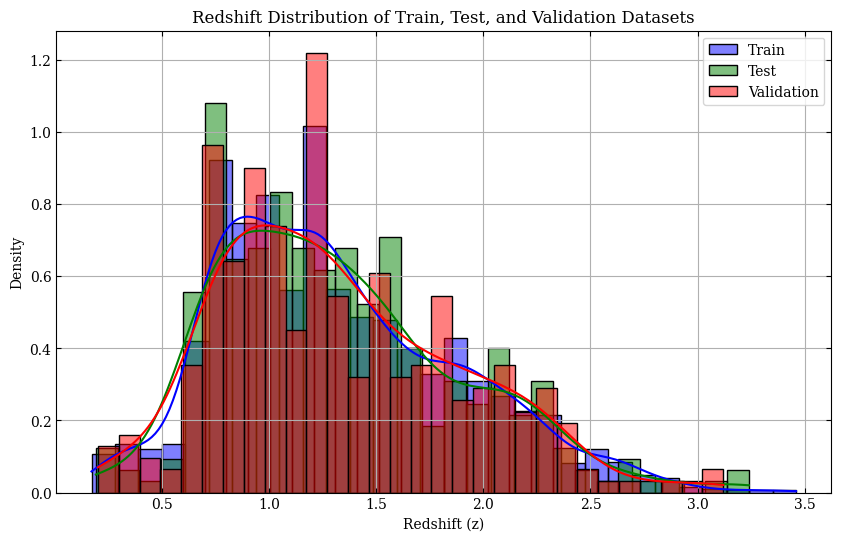

In [351]:
plt.figure(figsize=(10, 6))

# Plot the distribution of redshift for train, test, and validation datasets
sns.histplot(train_df['z'], bins=30, kde=True, color='blue', label='Train', stat='density')
sns.histplot(test_df['z'], bins=30, kde=True, color='green', label='Test', stat='density')
sns.histplot(val_df['z'], bins=30, kde=True, color='red', label='Validation', stat='density')

plt.xlabel('Redshift (z)')
plt.ylabel('Density')
plt.title('Redshift Distribution of Train, Test, and Validation Datasets')
plt.legend()
plt.grid(True)
plt.show()

In [352]:
valid_loader = DataLoader(CustomLoadDataset_Redshift(val_df,val_additional_data), batch_size=50, shuffle=True,drop_last=True)
test_loader = DataLoader(CustomLoadDataset_Redshift(test_df,test_additional_data), batch_size=32, shuffle=True,drop_last=True)

In [353]:
n=1
epochs = 300
batch_size = 16
lr = 5e-2 #orig = 0.001 or 1e-3, best with 5e-5

# config = {
#     "input_size": 7781,
#     "d_model": 512,
#     "nhead": 8,
#     "num_encoder_layers": 3,
#     "num_decoder_layers": 3,
#     "dim_feedforward": 2048,
#     "learning_rate": lr,
#     "batch_size": 64,
#     "num_mlp_blocks": 4,
#     "mlp_dim": 512,
#     "dropout_rate": 0.4
# }

config = {
    "input_size": 7781,
    "d_model": 512,
    "nhead": 8,
    "num_encoder_layers": 3,
    "num_decoder_layers": 3,
    "dim_feedforward": 2048,
    "learning_rate": 5e-5,
    "batch_size": 64,  # Reduced batch size
    "num_mlp_blocks": 1,  # Reduced from 4
    "mlp_dim": 512,
    "dropout_rate": 0.8,
    "weight_decay": 1e-3  # Added weight decay
}


In [354]:
train_loader = DataLoader(CustomLoadDataset_Redshift(train_df,train_additional_data), batch_size=batch_size, shuffle=True,drop_last=True)

In [355]:
def check_data_consistency(train_loader, valid_loader):
    # Check basic statistics
    print("## Dataset Size Check")
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Validation samples: {len(valid_loader.dataset)}")
    
    # Check data shapes and ranges
    def analyze_batch(loader, name):
        batch = next(iter(loader))
        spectra, redshift, additional_data, idx, t_id = batch
        
        print(f"\n## {name} Batch Analysis")
        print(f"Spectra shape: {spectra.shape}")
        print(f"Redshift shape: {redshift.shape}")
        print(f"Additional data shape: {additional_data.shape}")
        
        print("\n## Value Ranges")
        print(f"Spectra - min: {spectra.min():.4f}, max: {spectra.max():.4f}, mean: {spectra.mean():.4f}")
        print(f"Redshift - min: {redshift.min():.4f}, max: {redshift.max():.4f}, mean: {redshift.mean():.4f}")
        print(f"Additional - min: {additional_data.min():.4f}, max: {additional_data.max():.4f}, mean: {additional_data.mean():.4f}")
        
        # Check for NaN values
        print("\n## NaN Check")
        print(f"Spectra NaN: {torch.isnan(spectra).any()}")
        print(f"Redshift NaN: {torch.isnan(redshift).any()}")
        print(f"Additional NaN: {torch.isnan(additional_data).any()}")
        
        # Check for infinity values
        print("\n## Infinity Check")
        print(f"Spectra Inf: {torch.isinf(spectra).any()}")
        print(f"Redshift Inf: {torch.isinf(redshift).any()}")
        print(f"Additional Inf: {torch.isinf(additional_data).any()}")
        
        return spectra, redshift, additional_data, t_id

    print("\n=== Training Data Analysis ===")
    train_data = analyze_batch(train_loader, "Training")
    
    print("\n=== Validation Data Analysis ===")
    valid_data = analyze_batch(valid_loader, "Validation")
    
    # Check for overlapping IDs
    train_ids = set(train_data[3])
    valid_ids = set(valid_data[3])
    overlap = train_ids.intersection(valid_ids)
    
    print("\n## ID Overlap Analysis")
    print(f"Overlapping IDs: {len(overlap)}")
    if len(overlap) > 0:
        print("WARNING: Train and validation sets have overlapping IDs!")

# Usage:
check_data_consistency(train_loader, valid_loader)


## Dataset Size Check
Training samples: 2476
Validation samples: 311

=== Training Data Analysis ===

## Training Batch Analysis
Spectra shape: torch.Size([16, 7781])
Redshift shape: torch.Size([16, 1])
Additional data shape: torch.Size([16, 49])

## Value Ranges
Spectra - min: -1.7769, max: 30.4519, mean: 1.4340
Redshift - min: 0.5700, max: 2.7300, mean: 1.5400
Additional - min: 0.0000, max: 1.0000, mean: 0.3177

## NaN Check
Spectra NaN: False
Redshift NaN: False
Additional NaN: False

## Infinity Check
Spectra Inf: False
Redshift Inf: False
Additional Inf: False

=== Validation Data Analysis ===

## Validation Batch Analysis
Spectra shape: torch.Size([50, 7781])
Redshift shape: torch.Size([50, 1])
Additional data shape: torch.Size([50, 49])

## Value Ranges
Spectra - min: -2.9406, max: 8.6152, mean: 0.9980
Redshift - min: 0.2000, max: 2.2900, mean: 1.2686
Additional - min: 0.0000, max: 1.0000, mean: 0.3222

## NaN Check
Spectra NaN: False
Redshift NaN: False
Additional NaN: False

#

In [356]:
accelerator = Accelerator()

model = SpecPT(input_size=7781) #, d_head=16
# model.load_state_dict(torch.load('redshift_prediction_model_1D_large_kernel_staggered_training.pth'))

# Load the model state
file_path = os.path.expanduser('~/research/galax_spec/pretrained_weights')
# state_dict = torch.load(f'{file_path}/SpecPT_DESI_combined_autoencoder_150.pth', map_location='cpu')  # Load to CPU first 
state_dict = torch.load(f'{file_path}/SpecPT_training_HST_150.pth', map_location='cpu')  # Load to CPU first 
model.load_state_dict(state_dict)
model.to(accelerator.device)
# Initialize the modified SpecPT model for redshift prediction
# redshift_model = SpecPTForRedshift(model)  # `model` is the pretrained SpecPT instance
# Determine the additional_features_dim based on the shape of the additional data
additional_features_dim = data_sed_chi_l5['flux'][0].shape[0]

redshift_model = EnhancedSpecPTForRedshift(
    model, 
    additional_features_dim=additional_features_dim,
    output_features=1, 
    num_mlp_blocks=config["num_mlp_blocks"], 
    mlp_dim=config["mlp_dim"], 
    dropout_rate=config["dropout_rate"]
)

# Load the model state
# state_dict = torch.load('../SpecPT_DESI_BGS_redshift_prediction_model_complex_MLP_residual_2.pth', map_location='cpu')  # Load to CPU first
# state_dict = torch.load('saved_models/SpecPT_HST_redshift_model_400.pth', map_location='cpu')  # Load to CPU first
state_dict = torch.load(f'{file_path}/SpecPT_DESI_Combined_EnhancedSpecPTForRedshift_500.pth', map_location='cpu')  # Load to CPU first
# Load the model state while ignoring missing keys
missing_keys, unexpected_keys = redshift_model.load_state_dict(state_dict, strict=False)
print(f"Missing keys: {missing_keys}")
print(f"Unexpected keys: {unexpected_keys}")

/home/ckb2084/conda/envs/pytorch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)

/tmp/ipykernel_3599441/1225327780.py:9: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We reco

Missing keys: ['additional_projection.0.weight', 'additional_projection.0.bias', 'additional_projection.1.weight', 'additional_projection.1.bias', 'additional_projection.4.weight', 'additional_projection.4.bias', 'additional_bn.weight', 'additional_bn.bias', 'additional_bn.running_mean', 'additional_bn.running_var', 'pre_attention_fusion.0.weight', 'pre_attention_fusion.0.bias', 'pre_attention_fusion.1.weight', 'pre_attention_fusion.1.bias', 'pre_attention_fusion.3.weight', 'pre_attention_fusion.3.bias', 'pre_attention_fusion.6.weight', 'pre_attention_fusion.6.bias']
Unexpected keys: ['mlp_blocks.1.linear1.weight', 'mlp_blocks.1.linear1.bias', 'mlp_blocks.1.linear2.weight', 'mlp_blocks.1.linear2.bias', 'mlp_blocks.1.layer_norm.weight', 'mlp_blocks.1.layer_norm.bias', 'mlp_blocks.2.linear1.weight', 'mlp_blocks.2.linear1.bias', 'mlp_blocks.2.linear2.weight', 'mlp_blocks.2.linear2.bias', 'mlp_blocks.2.layer_norm.weight', 'mlp_blocks.2.layer_norm.bias', 'mlp_blocks.3.linear1.weight', 'mlp_

/tmp/ipykernel_3599441/1225327780.py:29: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [357]:
print(redshift_model)

EnhancedSpecPTForRedshift(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (proj_to_d_model): Linear(in_features=124672, out_features=512, bias=True)
  (additional_projection): Sequential(
    (0): Linear(in_features=49, out_features=512, bias=True)
    (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (2): Swish()
    (3): 

In [358]:

criterion = NMADLoss(normalization_factor='std')



optimizer = torch.optim.Adam(redshift_model.parameters(), lr=config["learning_rate"],
                             weight_decay=config["weight_decay"])
# Define different learning rates for different parts of the model
# lr_encoder = 1e-6  # Learning rate for pre-trained encoder layers
# lr_new_layers = 1e-4  # Learning rate for new layers (MLP and attention)

# # Split the model's parameters into different groups
# optimizer = torch.optim.Adam([
#     {'params': redshift_model.encoder.parameters(), 'lr': lr_encoder},  # Pre-trained encoder with a smaller learning rate
#     {'params': redshift_model.proj_to_d_model.parameters(), 'lr': lr_encoder},  # Pre-trained projection layer
#     # {'params': redshift_model.forward_conv.parameters(), 'lr': lr_encoder},  # Pre-trained forward convolution layer
#     {'params': redshift_model.mlp_blocks.parameters(), 'lr': lr_new_layers},  # New MLP blocks with a higher learning rate
#     {'params': redshift_model.prediction.parameters(), 'lr': lr_new_layers},  # New prediction layers with a higher learning rate
#     {'params': redshift_model.attention.parameters(), 'lr': lr_new_layers}  # New attention layers with a higher learning rate
# ])


# Initialize Accelerator

redshift_model, train_loader, valid_loader, optimizer, criterion = accelerator.prepare(redshift_model, train_loader, valid_loader, optimizer, criterion)


In [359]:
def evaluate(net, loader, criterion, accelerator):
    net.eval()
    total_loss = 0
    total_samples = 0

    with torch.no_grad():
        for X, Y, additional_data, idx,t_id in loader:
            X, Y = accelerator.prepare(X, Y)
            output = net(X,additional_data)
            loss = criterion(output, Y)
            total_loss += loss.item()
            total_samples += X.size(0)

    average_loss = total_loss / total_samples
    return average_loss

In [360]:
start_time = time()
best_val_loss, overfit, patience = np.inf, 0, 5000
t_loss = []
v_loss = []
for epoch in range(epochs):
    redshift_model.train()
    train_loss = 0.0
    for step, (X, Y, additional_data, idx,t_id) in enumerate(train_loader):
        pred = redshift_model(X, additional_data)
        loss = criterion(pred, Y)
        train_loss += loss.item()
        
        # Backward pass and optimize
        accelerator.backward(loss)
        optimizer.step()
        optimizer.zero_grad()

    train_loss /= len(train_loader.dataset)
    t_loss.append(train_loss)
    
    # Early stopping
    redshift_model.eval()
    if valid_loader is not None:
        val_loss = evaluate(redshift_model, valid_loader, criterion, accelerator)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            torch.save(redshift_model.state_dict(), 'saved_models/SpecPT_HST_redshift_model_DESI_combined_PT_Enhanced_'+str(epochs*n)+'.pth')
            overfit = 0
        else:
            overfit += 1
            if overfit >= patience:
                redshift_model.load_state_dict(torch.load('saved_models/SpecPT_HST_redshift_model_DESI_combined_PT_Enhanced_'+str(epochs*n)+'.pth'))
                break
        v_loss.append(val_loss)
        val_time = time()
        if epoch == 0:
            completion_time = epochs * n * (val_time - start_time)
            hours = completion_time // 3600
            completion_time = completion_time - 3600 * hours
            minutes = completion_time // 60
            seconds = completion_time - 60 * minutes
            print('Estimated Completion Time:')
            print('%dh%dm%ds' % (hours, minutes, seconds))
            print('\n')
        temp = val_time - start_time
        hours = temp // 3600
        temp = temp - 3600 * hours
        minutes = temp // 60
        seconds = temp - 60 * minutes

        print('Epoch:', epoch, '\n\tTrain loss:', train_loss)
        print('\tVal Loss:', val_loss)
        print('\tBest Val Loss:', best_val_loss)
        print('\tBest Epoch:', best_epoch)
        print('Time elapsed since start:')
        print('%dh%dm%ds' % (hours, minutes, seconds))
        if np.isnan(train_loss):
            print("Loss is NaN. Stopping training.")
            break


Estimated Completion Time:
0h13m47s


Epoch: 0 
	Train loss: 0.055638986108568836
	Val Loss: 0.016785823901494343
	Best Val Loss: 0.016785823901494343
	Best Epoch: 0
Time elapsed since start:
0h0m2s
Epoch: 1 
	Train loss: 0.0512336321138989
	Val Loss: 0.015834912061691284
	Best Val Loss: 0.015834912061691284
	Best Epoch: 1
Time elapsed since start:
0h0m5s
Epoch: 2 
	Train loss: 0.04951567413444858
	Val Loss: 0.015281986991564432
	Best Val Loss: 0.015281986991564432
	Best Epoch: 2
Time elapsed since start:
0h0m8s
Epoch: 3 
	Train loss: 0.0478843237259854
	Val Loss: 0.014817805091540018
	Best Val Loss: 0.014817805091540018
	Best Epoch: 3
Time elapsed since start:
0h0m11s
Epoch: 4 
	Train loss: 0.04864164007307062
	Val Loss: 0.014386561512947083
	Best Val Loss: 0.014386561512947083
	Best Epoch: 4
Time elapsed since start:
0h0m13s
Epoch: 5 
	Train loss: 0.04700315126213388
	Val Loss: 0.014413067102432252
	Best Val Loss: 0.014386561512947083
	Best Epoch: 4
Time elapsed since start:
0h0m16s


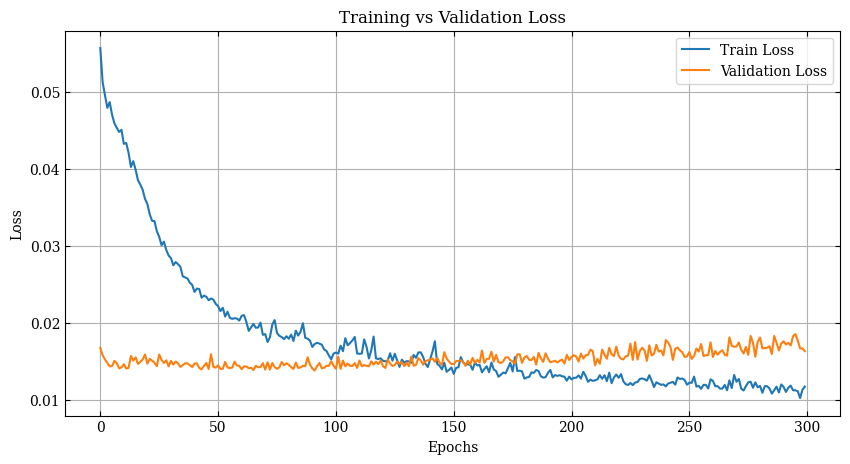

In [361]:
plt.figure(figsize=(10, 5))
plt.plot(t_loss, label='Train Loss')
plt.plot(v_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_3599441/955381212.py:13: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_3599441/955381212.py:29: FutureWarning:

You are using `torch.load` with

eta =  48.75
rmse =  0.5265864598080473
rmse/(1+z) =  0.22237824479986024
nmad =  0.21145864073686443
nmad2 =  0.21241995985758264


/tmp/ipykernel_3599441/955381212.py:166: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



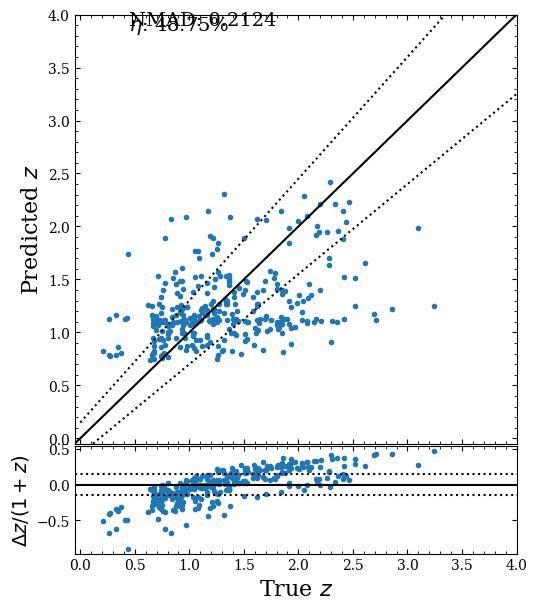

In [279]:
from functools import reduce
import operator
# Initialize the Accelerator
accelerator = Accelerator()

model = SpecPT(input_size=7781) #, d_head=16
# model.load_state_dict(torch.load('redshift_prediction_model_1D_large_kernel_staggered_training.pth'))

# Load the model state
# state_dict = torch.load('saved_models/SpecPT_training_HST_150.pth', map_location='cpu')  # Load to CPU first 
file_path = os.path.expanduser('~/research/galax_spec/pretrained_weights')
# state_dict = torch.load(f'{file_path}/SpecPT_DESI_combined_autoencoder_150.pth', map_location='cpu')
state_dict = torch.load(f'{file_path}/SpecPT_training_HST_150.pth', map_location='cpu')

model.load_state_dict(state_dict)
model.to(accelerator.device)
# Initialize the modified SpecPT model for redshift prediction
# redshift_model = SpecPTForRedshift(model)  # `model` is the pretrained SpecPT instance
redshift_model = EnhancedSpecPTForRedshift(
    model, 
    output_features=1, 
    num_mlp_blocks=config["num_mlp_blocks"], 
    mlp_dim=config["mlp_dim"], 
    dropout_rate=config["dropout_rate"],
    additional_features_dim=additional_features_dim
)

# Load the model state
state_dict = torch.load('saved_models/SpecPT_HST_redshift_model_DESI_combined_PT_Enhanced_'+str(epochs*n)+'.pth', map_location='cpu')  # Load to CPU first
# state_dict = torch.load('pretrained_weights/SpecPT_HST_redshift_model_DESI_combined_PT_Enhanced_'+'500.pth', map_location='cpu')  # Load to CPU first

redshift_model.load_state_dict(state_dict)

# Prepare the model and data loader using Accelerator
redshift_model, test_loader = accelerator.prepare(redshift_model, test_loader)
redshift_model = redshift_model.to(accelerator.device)
redshift_model.eval()


# model = model.to(DEVICE)
# model.eval()
# true = []
# preds = []
# with torch.no_grad():
#     for X, Y in test_loader:
#         X, Y = X.to(DEVICE), Y.to(DEVICE)
#         output = model(X)
#         for xx,yy in zip(Y.cpu().numpy().reshape((len(Y.cpu()),)),output.cpu().numpy().reshape((len(output.cpu()),))):
#             true.append(xx)
#             preds.append(yy)


# model = model.to(DEVICE)
true_class = []
preds_class = []
true_z = []
preds_z = []
indices = []
target_ids = []
with torch.no_grad():
    for X, Y, additional_data, idx,t_id in test_loader:
#         X, Y = X.to(DEVICE), Y.to(DEVICE)
        output = redshift_model(X,additional_data)
        true_z.extend(reduce(operator.concat, Y.tolist()))
        preds_z.extend(reduce(operator.concat, output.tolist()))
        # Assuming the first element of Y and output corresponds to class, and the second to z value
#         for y, out in zip(Y.tolist(), output.tolist()):
#             true_class.append(y[0])  # Assuming y[0] is class
#             preds_class.append(out[0])  # Assuming out[0] is predicted class
#             true_z.append(y[1])  # Assuming y[1] is z
#             preds_z.append(out[1])  # Assuming out[1] is predicted z
        indices.extend(idx.tolist())
        target_ids.extend(list(t_id))
#         for xx,yy in zip(Y.cpu().numpy().reshape((len(Y.cpu()),2)),output.cpu().numpy().reshape((len(output.cpu()),2))):
#             true_z.append(xx[1])
#             preds_z.append(yy[1])
#             true_class.append(xx[0])temp_df = pd.DataFrame({'index': indices, 'preds_z': preds_z, 'true_z': true_z})

temp_df = pd.DataFrame({'index': indices, 'grism_id': target_ids, 'preds_z': preds_z, 'true_z': true_z})
df_results_main = temp_df
df_results_main = df_results_main.set_index(['index'])
df_results_main.index.name = None
df_results_main

df_results = pd.merge(test_df, df_results_main, on='grism_id')
# df_results = temp_df
# df_results = df_results[df_results['target']!=-1]

# Load your data here
# df_results = pd.read_csv('../results_8Sep22_lr.001_ep32_flux_and_wl_norm.csv')
from matplotlib.gridspec import GridSpec
plt.rcdefaults()

mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

# df_results = df_results.sort_values(by='ZQUALITY',ascending=False)
# df_results = df_results[df_results['ZQUALITY']==4]

fig = plt.figure(figsize=(5.7, 7))
gs = GridSpec(2, 1, height_ratios=[4, 1], wspace=0.1,hspace=0.01) #width_ratios=[10, 1]

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
# cax = fig.add_subplot(gs[:, 1])


delz = (df_results['true_z']-df_results['preds_z'])/(1+df_results['true_z'])
delta = (df_results['true_z']-df_results['preds_z'])
nmad = 1.48*np.median(np.abs(delz))
nmad2 = 1.48*np.median(np.abs((delta - np.median(delta))/(1+df_results['true_z'])))
# print(nmad)
rmse = np.sqrt(np.mean(delz**2))
frac = 0.15
eta = 100*len(delz[np.abs(delz)>frac])/len(delz)
print('eta = ',eta)
print('rmse = ',np.sqrt(np.mean((df_results['true_z']-df_results['preds_z'])**2)))
print('rmse/(1+z) = ',rmse)
print('nmad = ',nmad)
print('nmad2 = ',nmad2)
# rmse2 = np.sqrt(np.mean((df_results['true']-df_results['predicted'])**2))
min_lim = -0.05
max_lim = np.ceil(df_results['true_z'].max())#7
avg = (min_lim+max_lim)/2
ax1.text(min_lim+0.5,max_lim-0.1,r'NMAD: '+str(np.round(nmad2,4)),fontdict={'size':14})
ax1.text(min_lim+0.5,max_lim-0.15,r'$\eta$: '+str(np.round(eta,2))+'%',fontdict={'size':14})
ax1.plot([min_lim,max_lim],[min_lim,max_lim],zorder=9,c='k')

x = np.linspace(0,np.ceil(df_results['z'].max()))
y1 = ((1+x)*frac)+x
y2 = ((1+x)*-frac)+x
ax1.plot(x,y1,zorder=9,c='k',linestyle='dotted')
ax1.plot(x,y2,zorder=9,c='k',linestyle='dotted')

# Plot the first subplot with color
sc1 = ax1.scatter(df_results['true_z'], df_results['preds_z'], zorder=8, marker='.')
ax1.set_ylabel(r'Predicted $z$', fontsize=16)
# xspace = np.linspace(0.1,6.1)
# print(xspace)
# ax1.plot(0.15*(xspace),0.15*xspace,linestyle='dotted',c='k')
# ax1.plot(xspace,0.15*(1+xspace),linestyle='dotted',c='k')
ax1.set_xlim(min_lim, max_lim)
ax1.set_ylim(min_lim, max_lim)
ax1.minorticks_on()

# Plot the second subplot with color
sc2 = ax2.scatter(df_results['true_z'], delz, zorder=8, marker='.')
ax2.axhline(y=0, c='k', zorder=9, linestyle='solid')
ax2.axhline(y=-frac, c='k', zorder=9, linestyle='dotted')
ax2.axhline(y=frac, c='k', zorder=9, linestyle='dotted')
ax2.set_ylabel(r'$\Delta z/(1+z)$', fontsize=14)
ax2.set_xlabel(r'True $z$', fontsize=16)
# ax2.set_ylim(-0.22,0.22)

# Remove x-tick labels for ax1
plt.setp(ax1.get_xticklabels(), visible=False)

# # Create a single color bar for both subplots
# cbar = plt.colorbar(sc1, cax=cax, orientation='vertical', pad=0.02)
# cbar.set_label('Confidence/Probability', fontsize=14)  # Customize the color bar label

# Adjust the layout
plt.tight_layout()

# Save or show the plot
# plt.savefig('../results_8Sep22_lr.001_ep32_flux_and_wl_norm.png', dpi=1200)
plt.show()

In [280]:
# # Calculate necessary values
# delz = (bgs_results['true_z'] - bgs_results['preds_z']) / (1 + bgs_results['true_z'])
# delta = bgs_results['true_z'] - bgs_results['preds_z']
# nmad = 1.48 * np.median(np.abs(delz))
# nmad2 = 1.48 * np.median(np.abs((delta - np.median(delta)) / (1 + bgs_results['true_z'])))
# rmse = np.sqrt(np.mean(delz**2))
# frac = 0.15
# eta = 100 * len(delz[np.abs(delz) > frac]) / len(delz)

# Print statistics
print(f'eta = {eta}')
print(f'rmse = {np.sqrt(np.mean((df_results["true_z"] - df_results["preds_z"])**2))}')
print(f'rmse/(1+z) = {rmse}')
print(f'nmad = {nmad}')
print(f'nmad2 = {nmad2}')

# Set up the figure with subplots
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.02,
                    row_heights=[0.8, 0.2])

# Define axis limits
min_lim = -0.05
# max_lim = np.ceil(bgs_results['true_z'].max())
max_lim = df_results['true_z'].max()+0.1

# Add scatter plot to the first subplot
fig.add_trace(
    go.Scatter(
        x=df_results['true_z'], 
        y=df_results['preds_z'], 
        mode='markers',
        marker=dict(size=2, color='steelblue', opacity=0.5),
        name='Data points',
        hovertemplate='<b>TARGETID</b>: %{customdata}<br>' +
                      '<b>True z</b>: %{x:.4f}<br>' +
                      '<b>Predicted z</b>: %{y:.4f}<br>',
        customdata=df_results['grism_id']
    ),
    row=1, col=1
)

# Add identity line
fig.add_trace(
    go.Scatter(x=[min_lim, max_lim], y=[min_lim, max_lim], mode='lines', 
               line=dict(color='black', width=0.5), name='y=x'),
    row=1, col=1
)

# Add dotted lines
# x = np.linspace(0, np.ceil(bgs_results['true_z'].max()), 100)
x = np.linspace(0, df_results['true_z'].max()+0.1, 100)
y1 = ((1 + x) * frac) + x
y2 = ((1 + x) * -frac) + x

fig.add_trace(
    go.Scatter(x=x, y=y1, mode='lines', line=dict(color='black', dash='dot'), 
               showlegend=False),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=x, y=y2, mode='lines', line=dict(color='black', dash='dot'), 
               showlegend=False),
    row=1, col=1
)

# Add scatter plot to the second subplot
fig.add_trace(
    go.Scatter(
        x=df_results['true_z'], 
        y=delz, 
        mode='markers',
        marker=dict(size=2, color='steelblue', opacity=0.5),
        name='Δz/(1+z)',
        hovertemplate='<b>TARGETID</b>: %{customdata}<br>' +
                      '<b>True z</b>: %{x:.4f}<br>' +
                      '<b>Δz/(1+z)</b>: %{y:.4f}<br>',
        customdata=df_results['grism_id']
    ),
    row=2, col=1
)

# Add horizontal lines to the second subplot
fig.add_hline(y=0, line=dict(color='black', width=0.5), row=2, col=1)
fig.add_hline(y=frac, line=dict(color='black', dash='dot'), row=2, col=1)
fig.add_hline(y=-frac, line=dict(color='black', dash='dot'), row=2, col=1)

# Update layout
fig.update_layout(
    height=700, width=570,
#     title_text='Redshift Prediction Results',
    showlegend=False,
    annotations=[
        dict(
            x=0.05, y=0.95,
            xref='paper', yref='paper',
            text=f'NMAD: {nmad2:.4f}<br>η: {eta:.2f}%',
            showarrow=False,
            font=dict(size=14, color='black')
        )
    ],
    plot_bgcolor='white',
    margin=dict(l=50, r=50, t=50, b=50)
)

# Update axes
fig.update_xaxes(title_text='True z', row=2, col=1, title_font=dict(size=18, color='black'))
fig.update_yaxes(title_text='Predicted z', row=1, col=1, title_font=dict(size=18, color='black'))
fig.update_yaxes(title_text='Δz/(1+z)', row=2, col=1, title_font=dict(size=18, color='black'))

fig.update_xaxes(
    showline=True,  # Show the line on the x-axis
    tickfont=dict(size=14, color='black'), 
    linecolor='black',  # Color of the x-axis line
    linewidth=2,  # Width of the x-axis line
    mirror='allticks',  # Mirror axis line and ticks on the opposite side (top)
    ticks='inside',  # Position ticks inside the plot
)
fig.update_yaxes(
    showline=True,  # Show the line on the y-axis
    tickfont=dict(size=14, color='black'), 
    linecolor='black',  # Color of the y-axis line
    linewidth=2,  # Width of the y-axis line
    mirror='allticks',  # Mirror axis line and ticks on the opposite side (right)
    ticks='inside',  # Position ticks inside the plot
)


# Update axes limits
fig.update_xaxes(range=[min_lim, max_lim], row=1, col=1)
fig.update_yaxes(range=[min_lim, max_lim], row=1, col=1)

# Show the plot
fig.show()

eta = 48.75
rmse = 0.5265864598080473
rmse/(1+z) = 0.22237824479986024
nmad = 0.21145864073686443
nmad2 = 0.21241995985758264
